# Gaussianization Flows (Details)

In [18]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [75]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import objax
import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Demo Data

<Figure size 432x288 with 0 Axes>

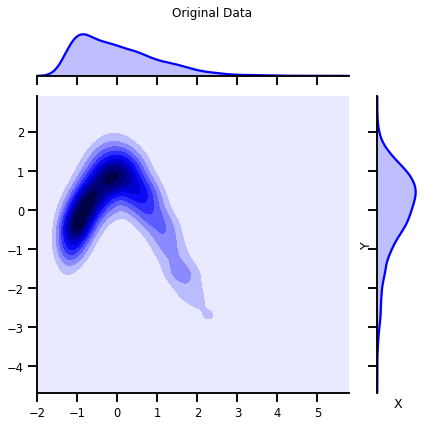

In [76]:
from sklearn.preprocessing import StandardScaler
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)
data = StandardScaler().fit_transform(data)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

In [77]:
X = jnp.array(data, dtype=np.float32)

### Model

#### Layer 1 - Mixture Gaussian CDF Transform

In [79]:
KEY

DeviceArray([  0, 123], dtype=uint32)

In [37]:
from rbig_jax.transforms.parametric.mixture import MixtureGaussianCDF

# layer parameters
n_components = 10


# create layer
init_func = MixtureGaussianCDF(n_components=n_components)

# initialize the keys
rng, params_rng = jax.random.split(KEY, 2)

# initialize the layer
params, forward_f, inverse_f = init_func(rng=params_rng, n_features=n_features)


In [38]:
%%time

# forward transformation
X_l1, log_abs_det = forward_f(params, X)

# inverse transformation
X_approx, log_abs_det = inverse_f(params, X_l1)

CPU times: user 7.79 s, sys: 724 ms, total: 8.51 s
Wall time: 3.99 s


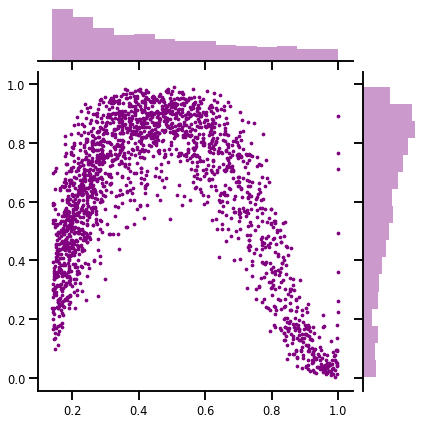

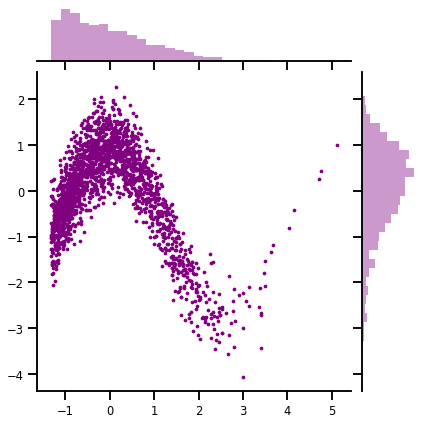

In [39]:
# plot data
sns.jointplot(X_l1[:, 0], X_l1[:, 1], s=5, color='purple')
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='purple')

#### Layer II - Inverse Gaussian CDF Transformation

In [40]:
from rbig_jax.transforms.inversecdf import InverseGaussCDF


# create layer
init_func = InverseGaussCDF(eps=1e-5)


# initialize the keys
rng, params_rng = jax.random.split(rng, 2)

# initialize the parameters
params, forward_f, inverse_f = init_func(rng=params_rng, n_features=n_features,)

In [41]:
%%time

# forward transformation
X_l2, log_abs_det = forward_f(params, X_l1)
X_l1_approx, _ = inverse_f(params, X_l2)

CPU times: user 68.1 ms, sys: 16.2 ms, total: 84.3 ms
Wall time: 61.9 ms


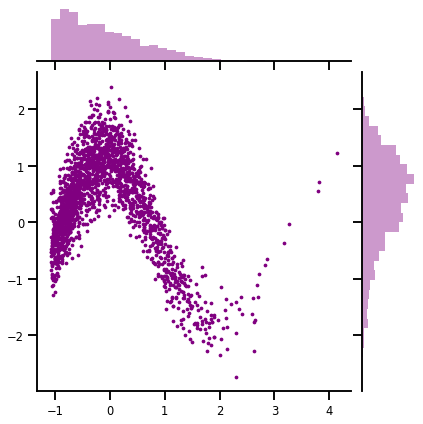

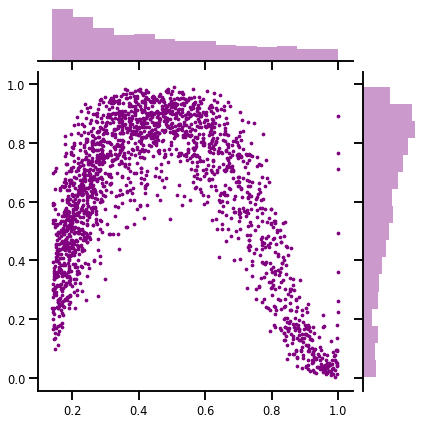

In [42]:
sns.jointplot(X_l2[:, 0], X_l2[:, 1], s=5, color='purple')
sns.jointplot(X_l1_approx[:, 0], X_l1_approx[:, 1], s=5, color='purple')

#### Layer 3 - HouseHolder Transformation

In [44]:
from rbig_jax.transforms.parametric import HouseHolder

# layer parameters
n_reflections = 10

init_func = HouseHolder(n_reflections=n_reflections)


# initialize the keys
rng, params_rng = jax.random.split(rng, 2)

# create layer
params, forward_f, inverse_f = init_func(rng=params_rng, n_features=n_features)

In [45]:
%%time

# forward transformation
Z, log_abs_det = forward_f(params, X_l2)
X_l2_approx, log_abs_det = inverse_f(params, Z)

CPU times: user 235 ms, sys: 8.96 ms, total: 244 ms
Wall time: 240 ms


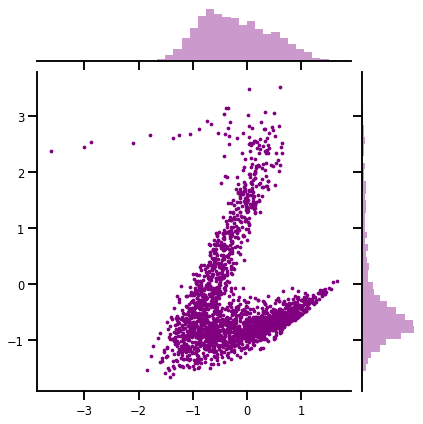

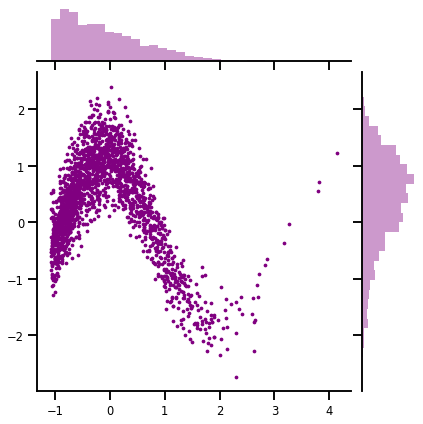

In [46]:
sns.jointplot(Z[:, 0], Z[:, 1], s=5, color='purple')
sns.jointplot(X_l2_approx[:, 0], X_l2_approx[:, 1], s=5, color='purple')

## Composing Transformations

In [66]:
bijectors = []
# mixture gaussian cdf distribution, f:[-inf,inf] -> [0,1]
bijectors.append(
    MixtureGaussianCDF(n_components=n_components)
)
# Logit quantile function, f:[0,1] -> [-inf,inf]
bijectors.append(
    InverseGaussCDF()
)
# orthogonal rotation layer, f:[-inf,inf] -> [-inf,inf]
bijectors.append(
    HouseHolder(n_reflections=n_reflections)
)



#### Initialize Parameters

In [67]:
# initialize params stores
all_params, forward_funs, inverse_funs = [], [], []

# create keys for all inits
rng, *layer_rngs = jax.random.split(KEY, num=len(bijectors) + 1)

# loop through bijectors
for i_rng, init_f in zip(layer_rngs, bijectors):
    
    param, forward_f, inverse_f = init_f(rng=i_rng, n_features=n_features)
    
    # store functions and parameters
    all_params.append(param)
    forward_funs.append(forward_f)
    inverse_funs.append(inverse_f)

#### Chaining Transformations

In [68]:
# init log det
logabsdet = np.zeros(X.shape[0])

inputs = X

# loop through functions
for forward_f, iparams in zip(forward_funs, all_params):
    
    # calculate log determinant jacobian, transformation
    inputs, ilogabsdet = forward_f(iparams, inputs)
    logabsdet += ilogabsdet

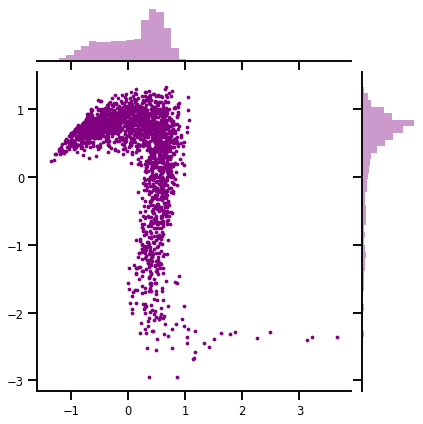

In [69]:
sns.jointplot(inputs[:, 0], inputs[:, 1], s=5, color='purple')

#### Inverse Chain Transformation

In [70]:
# init log det
logabsdet = np.zeros(X.shape[0])

X_approx = inputs

# loop through functions
for inverse_f, params in zip(inverse_funs[::-1], all_params[::-1]):
    
    # calculate log determin
    X_approx, ilogabsdet = inverse_f(params, X_approx)
    logabsdet += ilogabsdet

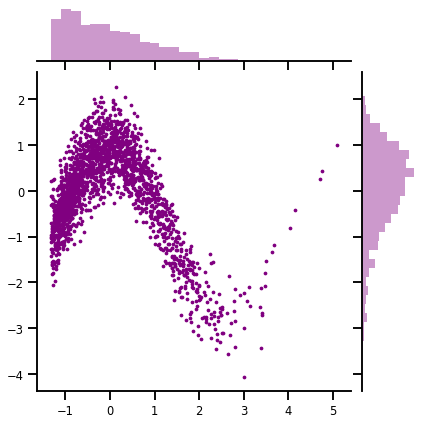

In [71]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='purple')

### More Layers

In [96]:
from rbig_jax.transforms.base import CompositeTransform

# model hyperparameters
n_components = 20
n_reflections = 2
n_features = data.shape[1]


n_layers = 2

bijectors = []

for _ in range(n_layers):
    # mixture gaussian cdf distribution, f:[-inf,inf] -> [0,1]
    bijectors.append(
        MixtureGaussianCDF(n_components=n_components)
    )
    # Logit quantile function, f:[0,1] -> [-inf,inf]
    bijectors.append(
        InverseGaussCDF()
    )
    # orthogonal rotation layer
    bijectors.append(
        HouseHolder(n_reflections=n_reflections)
    )


# initialize base distribution
base_dist = jax.scipy.stats.norm

# # initialize Model
# gf_model = GaussianizationFlow(n_features=n_features, bijections=transform, base_dist=base_dist)

#### Composite Transform

In [97]:
# compose all transformations into a single chain
init_func = CompositeTransform(bijectors)

In [98]:
# initialize the keys
rng, params_rng = jax.random.split(rng, 2)

# create layer
params, forward_f, inverse_f = init_func(rng=params_rng, n_features=n_features)

### Forward Transformation

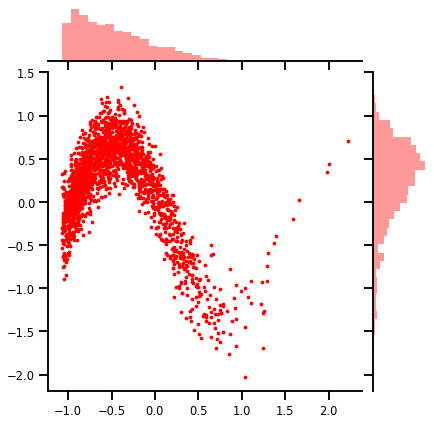

In [99]:
Z, _ = forward_f(params, X)

sns.jointplot(Z[:, 0], Z[:, 1], s=5, color='red')

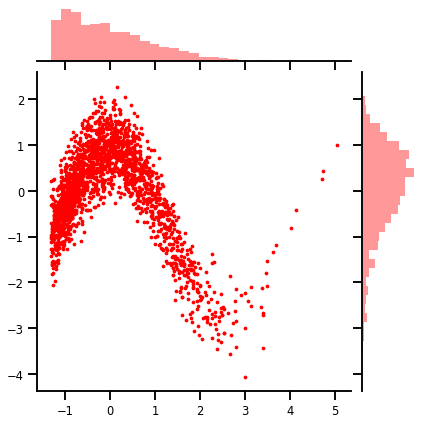

In [91]:
X_approx, _ = inverse_f(params, Z)

sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='red')

#### Loss Function

We're going to use the negative Log-Likelihood

In [127]:
@objax.Function.with_vars(gf_model.vars())
def nll_loss(x):
    return gf_model.score(x)

In [128]:
nll_loss(data)

DeviceArray(16.555227, dtype=float32)

##### Optimizer

In [129]:
# define the optimizer
opt = objax.optimizer.Adam(gf_model.vars())

# get grad values
gv = objax.GradValues(nll_loss, gf_model.vars())
lr = 0.01
epochs = 500
batch_size = 128

# define the training operation
@objax.Function.with_vars(gf_model.vars() + opt.vars())
def train_op(x):
    g, v = gv(x)  # returns gradients, loss
    opt(lr, g)
    return v

# This line is optional: it is compiling the code to make it faster.
train_op = objax.Jit(train_op)

#### Testing

100%|██████████| 500/500 [02:18<00:00,  3.62it/s, loss=1.8923]


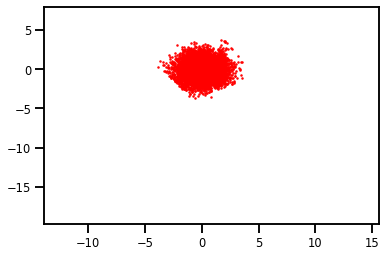

In [130]:
import itertools
from jax import device_put
import tqdm
from jax import random
from celluloid import Camera


# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

losses = list()


# initialize figure
fig = plt.figure()
camera = Camera(fig)

pbar = tqdm.trange(epochs)

with pbar:
    for i in pbar:
        
        if (i + 1) % 20 == 0 or i < 20:
            # make predictions
            Z = gf_model.transform(X_plot)
            plt.scatter(Z[:, 0], Z[:, 1], s=1, color="Red")
            camera.snap()

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, X)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss = float(train_op( train_data[batch_index:batch_index+batch_size])[0])
            # append batch
            avg_loss.append(loss)
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})
        

            
animation = camera.animate(250)
# HTML(animation.to_html5_video())
animation.save('training.gif')

#### Losses

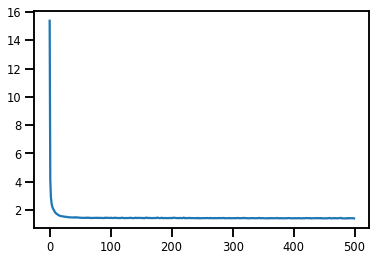

In [60]:
plt.plot(losses)

#### Forward Transformation

In [61]:
# forward transformation
z, logabsdet = gf_model(np.array(data))

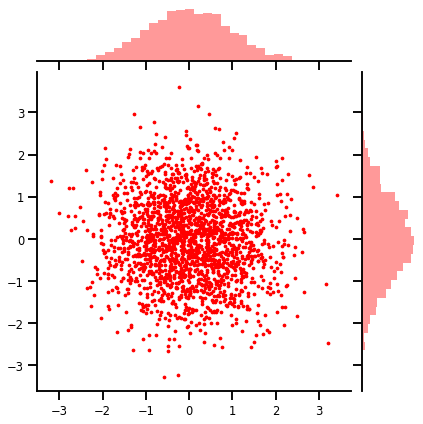

In [62]:
sns.jointplot(z[:, 0], z[:, 1], s=5, color='red')

### Application I - Generating Samples

In [63]:
# generate samples in the latent domain
n_gen_samples = 1_000
z_samples = objax.random.normal(shape=(n_gen_samples, n_features), generator=generator)

# inverse transformation
x_samples = gf_model.inverse_transform(z_samples)

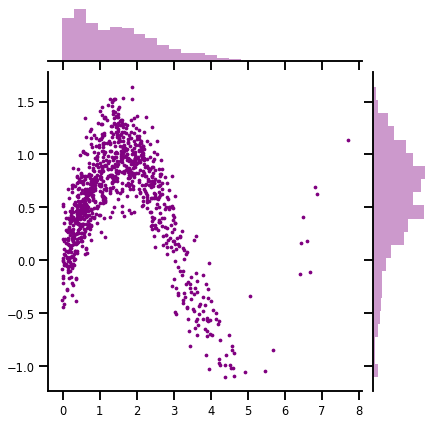

In [64]:
sns.jointplot(x_samples[:, 0], x_samples[:, 1], s=5, color='purple')

### Probability Density Estimation

In [65]:
ngrid = 1_000
buffer = 0.1
xline = np.linspace(data[:,0].min()-buffer, data[:,0].max()+buffer, ngrid)
yline = np.linspace(data[:,1].min()-buffer, data[:,1].max()+buffer, ngrid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [66]:
# forward transformation
z, logabsdet = gf_model(xyinput)

In [67]:
# log probability
z_prob = jax.scipy.stats.norm.logpdf(z).sum(axis=1)

# change of variables
log_prob = z_prob + logabsdet

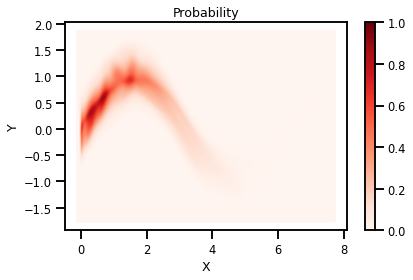

In [131]:
cmap = "Reds"
probs = np.exp(log_prob)
# probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs,  cmap=cmap, vmin=0.0, vmax=1.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()
plt.savefig("./probs.png")
plt.show()

### Demo of Transform between Layers

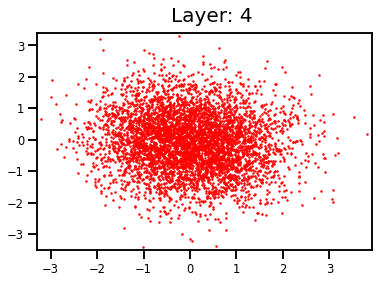

In [144]:
# initialize figure
fig, ax = plt.subplots()
camera = Camera(fig)

outputs = data
# ax.scatter(outputs[:, 0], outputs[:, 1], s=1, color="Red")
# ax.set_xlim([outputs[:,0].min()-.1, outputs[:,0].max()+.1])
# ax.set_ylim([outputs[:,1].min()-.1, outputs[:,1].max()+.1])
# ax.text(0.4, 1.05, f"Layer: {0}", transform=ax.transAxes, fontsize=20)
# camera.snap()


for ilayer, itransform in enumerate(gf_model.bijections._transforms):
    outputs = itransform.transform(outputs)    
    
    if (ilayer + 1) % 3 == 0:
        # make predictions
        ax.scatter(outputs[:, 0], outputs[:, 1], s=1, color="Red")
        ax.set_xlim([outputs[:,0].min()-.1, outputs[:,0].max()+.1])
        ax.set_ylim([outputs[:,1].min()-.1, outputs[:,1].max()+.1])
        ax.text(0.4, 1.05, f"Layer: {int((ilayer+1)/3)}", transform=ax.transAxes, fontsize=20)
        camera.snap()

animation = camera.animate(1_500)
# HTML(animation.to_html5_video())
animation.save('./layers.gif')